In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import os
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# 경고메세지 끄기
import warnings
warnings.filterwarnings("ignore")

In [58]:
# 데이터베이스 table 가져오기
base_path = os.getcwd()
transaction_new = pd.read_csv(base_path + '/transaction_final.csv')
customer = pd.read_csv(base_path + '/customer_final.csv')
product = pd.read_csv(base_path + '/product_final.csv')
sales = pd.read_csv(base_path + '/sales.csv')

In [4]:
transaction_new['created_at'] = pd.to_datetime(transaction_new['created_at'])

In [5]:
# 매출 그래프
df_combined = pd.merge(sales, transaction_new[['booking_id', 'created_at']], on='booking_id')

# 'created_at' 시간제거
df_combined['created_at'] = df_combined['created_at'].dt.tz_convert(None)


# 현재 날짜 설정
# snapshot_date : RFM 분석을 수행하는 현재 날짜(분석의 기준점)
snapshot_date = pd.to_datetime("2022-08-01")

# Recency 계산: 오늘 날짜 - 가장 최근 구매 날짜
rfm = df_combined.groupby('customer_id', as_index=False).agg({
    'created_at': lambda x: (snapshot_date - x.max()).days,
    'booking_id': 'nunique',
    'sales': 'sum'
})

# 컬럼 이름 변경
rfm.rename(columns={
    'created_at': 'Recency',
    'booking_id': 'Frequency',
    'sales': 'Monetary'
}, inplace=True)

In [6]:
from sklearn.preprocessing import minmax_scale

# 최근성(Recency)
rfm['Recency'] = minmax_scale(rfm['Recency'], axis=0, copy=True)
rfm['Recency'] = 1-rfm['Recency']

# 최빈성(Frequency)
rfm['Frequency'] = minmax_scale(rfm['Frequency'], axis=0, copy=True)

# 금액(Monetary)
rfm['Monetary'] = minmax_scale(rfm['Monetary'], axis=0, copy=True)

# RFM Score
rfm['Score']=rfm['Recency']+rfm['Frequency']+rfm['Monetary']

# RFM Score를 100점 만점 기준으로 scaling
rfm['Score']=minmax_scale(rfm['Score'], axis=0, copy=True)*100
rfm['Score']=round(rfm['Score'],0)

rfm.head()

,customer_id,Recency,Frequency,Monetary,Score
0,3,0.953297,0.070588,0.034775,40.0
1,8,0.895604,0.017647,0.005285,35.0
2,9,0.913462,0.014706,0.004569,36.0
3,11,0.800824,0.000000,0.000182,31.0
4,15,0.717033,0.005882,0.000625,28.0


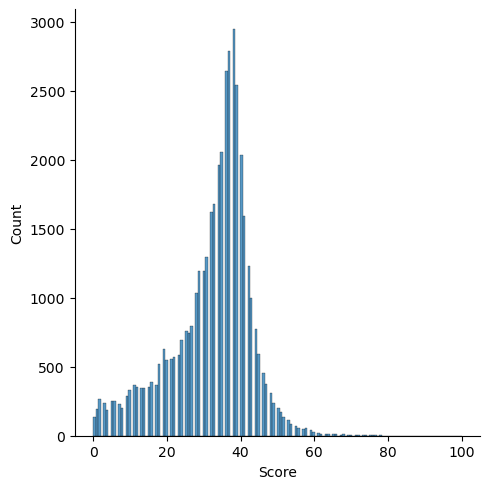

In [7]:
# RFM 점수에 따른 분포
sns.displot(rfm['Score']);

In [8]:
# RFM 점수에 따라 1~4까지 등급 부여(숫자가 1에 가까울수록 높은 등급)
rfm['Grade'] = rfm['Score'].apply(lambda x : 1 if x>=40 else 
                                  (2 if x>=35 else 
                                   (3 if x>=30 else 
                                    (4 if x>=25 else 5))))
rfm.head(5)

,customer_id,Recency,Frequency,Monetary,Score,Grade
0,3,0.953297,0.070588,0.034775,40.0,1
1,8,0.895604,0.017647,0.005285,35.0,2
2,9,0.913462,0.014706,0.004569,36.0,2
3,11,0.800824,0.000000,0.000182,31.0,3
4,15,0.717033,0.005882,0.000625,28.0,4


In [9]:
# RFM 점수 별 분포
rfm['Grade'].value_counts(normalize=True)

2    0.293761
1    0.220355
5    0.208230
3    0.175248
4    0.102407
Name: Grade, dtype: float64

### VIP 고객 분석

1. 타 고객 대비 VIP 고객 수는 22%이며, 전체 매출의 69%를 담당하는 충성 고객층입니다.
2. 타 고객 대비 VIP 고객의 객단가는 600,167 루피아로, 타 고객 대비 14.8% 높은 수준입니다.
3. VIP 고객 만의 특징을 알아보기 위하여 성별, 연령, 거주지, 선호 브랜드, 카테고리 등을 분석하였으나, VIP 고객 만의 특징은 발견되지 않았습니다.

#### 1. 전체 고객 중 VIP 고객 수와 매출 비중과 객단가 비교

In [10]:
# VIP 고객 수 (22%)
print(f"VIP 고객 수 : {rfm[rfm['Grade'] == 1]['customer_id'].nunique()}")
print(f"VIP 고객들 비중 : {round(rfm['Grade'].value_counts(normalize=True).loc[1] * 100)}%")

VIP 고객 수 : 9741
VIP 고객들 비중 : 22%


In [97]:
# 전체 고객 대비 VIP 고객 수
fig = px.pie(values=[rfm[rfm['Grade'] == 1]['customer_id'].nunique(), rfm[rfm['Grade'] != 1]['customer_id'].nunique()], names=['VIP 고객', '그 외 고객'], color_discrete_sequence=['#A0BFE0', '#4A55A2'])
fig.update_traces(pull = [0.1, 0], marker_line_color= "black",marker_line_width = 1, textinfo='value+percent', textfont_size=15)
fig.update_layout(
    {
        "title" : {
            "text" : "<b>전체 고객 중 <span style='color:blue;'>VIP 고객 비율</span> </b>",
            "x" : 0.5,
            "y" : 0.95,
            "font" : {"size":20}
        },
        "width" : 700
    },
    
    legend=dict(
    x=0.8, 
    y=0.93, 
    xanchor="left", 
    yanchor="middle",
    font=dict(size=16),
    traceorder='reversed'
    )
)

fig.show()

In [25]:
# VIP 고객들의 구매액이 전체 매출에서 차지하는 비중 (68.6%)
print(f"VIP 고객들의 구매액 : {sales[sales['customer_id'].isin(rfm[rfm['Grade'] == 1]['customer_id'])].sales.sum()}")
print(f"전체 매출 대비 VIP 고객들 매출 비중 : {round(sales[sales['customer_id'].isin(rfm[rfm['Grade'] == 1]['customer_id'])].sales.sum() / sales.sales.sum() * 100)}%")

VIP 고객들의 구매액 : 197479512724
전체 매출 대비 VIP 고객들 매출 비중 : 69%


In [35]:
# 전체 매출 대비 VIP 고객들 매출 비중
fig = px.pie(values=[0.69, 0.31], names=['VIP 고객 매출', '그 외 고객 매출'], color_discrete_sequence=['#4A55A2', '#A0BFE0'])
fig.update_traces(pull = [0.1, 0], marker_line_color= "black",marker_line_width = 1, textinfo='percent', textfont_size=15, rotation = 112)
fig.update_layout(
    {
        "title" : {
            "text" : "<b>전체 매출 대비 <span style='color:blue;'>VIP 고객 매출 비율</span> </b>",
            "x" : 0.5,
            "y" : 0.95,
            "font" : {"size":20}
        },
        "width" : 700
    },
    
    legend=dict(
    x=0.8, 
    y=0.93, 
    xanchor="left", 
    yanchor="middle",
    font=dict(size=16),
    )
)

fig.show()

In [12]:
# VIP 고객들과 그 외 고객들의 객단가 비교
print(f"VIP 고객들의 객단가 : {round((sales[sales['customer_id'].isin(rfm[rfm['Grade'] == 1]['customer_id'])].groupby('customer_id')['sales'].sum() / sales[sales['customer_id'].isin(rfm[rfm['Grade'] == 1]['customer_id'])].groupby('customer_id')['booking_id'].count()).mean())}")
print(f"그외 고객들의 객단가 : {round((sales[sales['customer_id'].isin(rfm[rfm['Grade'] != 1]['customer_id'])].groupby('customer_id')['sales'].sum() / sales[sales['customer_id'].isin(rfm[rfm['Grade'] != 1]['customer_id'])].groupby('customer_id')['booking_id'].count()).mean())}")


VIP 고객들의 객단가 : 600167
그외 고객들의 객단가 : 522514


#### 2. VIP 고객 성별 분석 (차이 없음)

In [52]:
# VIP 고객 개인정보
vips_id = rfm[rfm['Grade'] == 1].customer_id.unique()
non_vips_id = rfm[rfm['Grade'] != 1].customer_id.unique()
vips = customer[customer['customer_id'].isin(vips_id)]
non_vips = customer[customer['customer_id'].isin(non_vips_id)]

In [56]:
# 성별 분석
print(vips.gender.value_counts(normalize=True))
print(non_vips.gender.value_counts(normalize=True))

F    0.643466
M    0.356534
Name: gender, dtype: float64
F    0.641085
M    0.358915
Name: gender, dtype: float64


#### 3. VIP 고객 연령 분석 (차이 없음)

In [69]:
vips['age_now'].map(lambda x: '10대 미만' if x < 10 
                    else('10대' if x < 20
                         else ('20대 초반' if x < 25
                            else ('20대 후반' if x < 30
                                  else ('30대 초반' if x < 35
                                        else ('30대 후반' if x < 40
                                            else '40대 이상')))))).value_counts(normalize=True)

20대 후반    0.262807
20대 초반    0.249461
30대 초반    0.175547
10대       0.171748
30대 후반    0.091264
40대 이상    0.048352
10대 미만    0.000821
Name: age_now, dtype: float64

In [70]:
non_vips['age_now'].map(lambda x: '10대 미만' if x < 10 
                    else('10대' if x < 20
                         else ('20대 초반' if x < 25
                            else ('20대 후반' if x < 30
                                  else ('30대 초반' if x < 35
                                        else ('30대 후반' if x < 40
                                            else '40대 이상')))))).value_counts(normalize=True)

20대 후반    0.263311
20대 초반    0.258407
30대 초반    0.176411
10대       0.163499
30대 후반    0.089482
40대 이상    0.048020
10대 미만    0.000870
Name: age_now, dtype: float64

#### 4. VIP 고객 거주지 분석 (차이 없음)

In [95]:
vips['home_location'].value_counts(normalize=True).head(10)

Jakarta Raya          0.185299
Jawa Barat            0.117647
Jawa Tengah           0.109640
Jawa Timur            0.092496
Yogyakarta            0.082332
Lampung               0.053691
Kalimantan Barat      0.052767
Kalimantan Tengah     0.042193
Kalimantan Selatan    0.041679
Kalimantan Timur      0.030387
Name: home_location, dtype: float64

In [96]:
non_vips['home_location'].value_counts(normalize=True).head(10)

Jakarta Raya          0.184477
Jawa Barat            0.113681
Jawa Tengah           0.110721
Jawa Timur            0.098970
Yogyakarta            0.078253
Kalimantan Barat      0.055709
Lampung               0.055419
Kalimantan Tengah     0.043116
Kalimantan Selatan    0.041782
Kalimantan Timur      0.026984
Name: home_location, dtype: float64

#### 5. VIP 고객 선호 브랜드 분석 (차이 없음)

In [73]:
product.rename({'id' : 'product_id'}, axis=1, inplace=True)
vips_tran = transaction_new[transaction_new['customer_id'].isin(vips_id)].merge(product, how = 'left', on='product_id')
non_vips_tran = transaction_new[transaction_new['customer_id'].isin(non_vips_id)].merge(product, how='left', on='product_id')

In [79]:
vips_tran['brand'].value_counts(normalize=True).head(10)

nike        0.051413
puma        0.047252
adidas      0.046900
united      0.031418
catwalk     0.017077
fabindia    0.016957
gini        0.016141
arrow       0.015718
fastrack    0.015532
wrangler    0.015369
Name: brand, dtype: float64

In [80]:
non_vips_tran['brand'].value_counts(normalize=True).head(10)

nike        0.051304
puma        0.047871
adidas      0.046626
united      0.031635
fabindia    0.017320
catwalk     0.016905
gini        0.016152
arrow       0.015616
fastrack    0.015564
lino        0.015302
Name: brand, dtype: float64

#### 6. VIP 고객 선호 카테고리 분석 (차이없음)

In [81]:
vips_tran['masterCategory'].value_counts(normalize=True)

Apparel           0.481597
Accessories       0.253087
Footwear          0.208026
Personal Care     0.054315
Free Items        0.002422
Sporting Goods    0.000534
Home              0.000019
Name: masterCategory, dtype: float64

In [82]:
non_vips_tran['masterCategory'].value_counts(normalize=True)

Apparel           0.480907
Accessories       0.253566
Footwear          0.208200
Personal Care     0.054362
Free Items        0.002393
Sporting Goods    0.000556
Home              0.000016
Name: masterCategory, dtype: float64

In [ ]:
# rfm 관련 csv 파일 생성
rfm.to_csv('rfm.csv', index=False)